In [4]:
from egnn_pytorch import EGNN_Network
#import torch
import torch.nn as nn
import numpy as np
import glob
import time
import gzip
import math
import itertools
import torch
torch.manual_seed(0)

class RadialBasisFunction(torch.nn.Module):
    def __init__(self, num_basis=10, cutoff=5.0):
        super().__init__()
        self.cutoff = cutoff
        self.register_buffer('mu', torch.linspace(0, cutoff, num_basis))
        self.gamma = .1 # You can tune this

    def forward(self, distances):
        distances = distances.unsqueeze(-1) # shape (N, N, 1)
        rbf = torch.exp(-self.gamma * (distances - self.mu)**2)
        return rbf # shape (N, N, num_basis)

def pairwise_distances(x):
    diff = x.unsqueeze(1) -x.unsqueeze(0)
    dist = torch.norm(diff,dim=-1)
    return dist
# Example of aggregation function
def aggregate_rbf_features(rbf_features):
# Simple global mean aggregation
    global_features = rbf_features.mean(dim=(0,1))
    return global_features

def egnn(dim=1,learning_rate=.001):

    net=EGNN_Network(dim=dim,
    depth=2,
    num_positions=500, #no
    num_tokens=100,
    num_nearest_neighbors=1,
    #coor_weights_clamp_value = 2,
    norm_coors=True)

    optimizer= torch.optim.Adam(list(net.parameters()) + list(model.parameters()), lr=learning_rate)
    
    criterion = nn.L1Loss()



    return net, optimizer, criterion

def contrastive_loss(latent_features, species):
    """seperates latent space by enforcing dissimilarity between negative and positive ions"""

    loss = 0.0
    #print(species)
    positive_pairs = [(i, j) for i, j in itertools.combinations(range(len(species)), 2) if species[i] == species[j]]

    negative_pairs = [(i, j) for i, j in itertools.combinations(range(len(species)), 2) if species[i] != species[j]]
    #print(positive_pairs)
    #print(negative_pairs)

    # Positive pairs
    for i, j in positive_pairs:
        z_i, z_j = latent_features[i], latent_features[j]
        dist = torch.norm(z_i - z_j, p=3)  
        loss += dist ** 2  

    # Negative pairs
    for i, j in negative_pairs:
        z_i, z_j = latent_features[i], latent_features[j]
        dist = torch.norm(z_i - z_j, p=3) 
        loss += torch.clamp(dist, min=0) ** 2 #min 0 was the margin enforcement



    return loss / (len(positive_pairs) + len(negative_pairs))

from matplotlib import pyplot as plt
class TinyRegressor(nn.Module):
    def __init__(self, in_channels=13):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels, 1, 1, padding=1)
        self.conv2 = nn.Conv1d(1, 1, 1, padding=1)
            #nn.ReLU(),
        #nn.Conv1d(3,1,1, padding=1),
            #nn.ReLU()
        #)
        self.relu=nn.PReLU()
        self.pool = nn.AdaptiveMaxPool2d((1, 1)) #this one makes i all the samenumber
        self.out  = nn.Linear(1, 1)

    def forward(self, x):
        x = self.conv1(x)
        x=self.relu(x)
        x = self.conv2(x)
        x = self.pool(x)#.flatten(1)   # (B, 32)
        
        return self.out(x)

       # (B, 1)
    
model = TinyRegressor()
#plt.plot(torch.sum(global_embedding,dim=1).detach().numpy())

## PyTorch
#import torch

    
net, optimizer, criterion = egnn(dim=3, learning_rate=.01)

#lr_scheduler = CosineWarmupScheduler(optimizer=optimizer, warmup_epochs=10, max_epochs=40)

to=time.time()
last_len=0
#tlosses, losses=[],[]
pks=[]
outs=[]
ts=[]
attns=[]
train=np.char.array(glob.glob("/home/jrhoernschemeyer/Desktop/data_prep/egnn_encoder/*.npz"))

for i in range(5):
    
    #try:
        
    train = list(np.array(train)[np.random.permutation(len(train))])
    print("epoch",i)
    for j,path in enumerate(train[:20]):
        #with torch.zero_grad():
        charge=torch.tensor(0.0,requires_grad=True)
    

        #net.train()
        
        #losses=[]
        #model.train()
        optimizer.zero_grad()
        a=np.load(path,allow_pickle=True) #TODO
        zs,xs,y,ions=a["z"],a["pos"],torch.from_numpy(a["y"]),a["ions"]

        

        
        #lmbda = lambda epoch: 0.95
        
        #for epoch in range(100):
        
        for z,x,ion in zip(zs,xs,ions):
            #print(z)
            #try:
            x=torch.tensor(x).unsqueeze(0)
            z=torch.tensor(z.astype(np.int32)).unsqueeze(0)
            ionz=torch.tensor(ion,dtype=torch.int32).unsqueeze(0)

            #except:
                #print(pdb)
                #continue
            #print(z,x)
            out1=net(z,x)
            #print(len(out1[0]))
            #print(x)
            #print(z)
            # After EGNN outputs embeddings (h_i, x_i):
            distances = pairwise_distances(out1[1])
            rbf = RadialBasisFunction()(distances)

            global_rbf_features = aggregate_rbf_features(rbf)

            # Aggregate node embeddings too
            global_node_features = out1[0].mean(dim=0)

            # Concatenate node embeddings and RBF features
            global_embedding = torch.hstack([global_node_features, global_rbf_features])

            # Predict energy scalar
            energy_pred = model(global_embedding.unsqueeze(2))
            L = contrastive_loss(energy_pred, ionz[0])
            #print(sum(energy_pred))
            print(energy_pred)
            L.backward()
            optimizer.step()
            #print(torch.sum(out1,dim=1))
            #tlosses.append(L)
            
            #charge = charge + torch.mean(torch.sum(out1,dim=1)) #TODO
            
            
            
            #loss = criterion(torch.sum(x),torch.tensor(y))
            
            #losses.append(np.round(L.item(),3))
            #loss.backward(retain_graph=True)
            #torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=.1)

        #if losses:
            #tlosses.append(losses)

        #print(charge,y)
        #loss=criterion(charge,y)
        #losses.append(np.round(loss.item(),3))
        #losses.append(np.round(L.item(),3))
        print(L.item())
        #loss.backward()
        #optimizer.step()
        
        #lr_scheduler.step()

            
    

        

    #except Exception as error:
        #print('Caught this error: ' + repr(error))#except:
        #print(print(path[-8:-4]))
        #continue    

epoch 0
tensor([[[0.6298]],

        [[0.6541]],

        [[0.6369]],

        [[0.6263]],

        [[0.6572]],

        [[0.6222]],

        [[0.6372]],

        [[0.6647]],

        [[0.6667]],

        [[0.6227]],

        [[0.6720]],

        [[0.6554]],

        [[0.6320]],

        [[0.6372]],

        [[0.6345]]], grad_fn=<AddBackward0>)
tensor([[[0.6260]],

        [[0.6361]],

        [[0.6431]],

        [[0.6210]],

        [[0.6474]],

        [[0.6210]],

        [[0.6437]],

        [[0.6555]],

        [[0.6458]],

        [[0.6308]],

        [[0.6609]],

        [[0.6359]],

        [[0.6391]],

        [[0.6438]],

        [[0.6210]],

        [[0.6473]],

        [[0.6423]],

        [[0.6234]],

        [[0.6461]],

        [[0.6690]],

        [[0.6249]],

        [[0.6516]],

        [[0.6423]]], grad_fn=<AddBackward0>)
tensor([[[0.6229]],

        [[0.6412]],

        [[0.6280]],

        [[0.6199]],

        [[0.6408]],

        [[0.6199]],

        [[0.6289]],


KeyboardInterrupt: 

In [163]:
from egnn_pytorch import EGNN_Network
#import torch
import torch.nn as nn
import numpy as np
import glob
import time
import gzip
import math
import itertools


def egnn(dim=1,learning_rate=.001):

    net=EGNN_Network(dim=dim,
    depth=2,
    num_positions=500, #no
    num_tokens=100,
    num_nearest_neighbors=1,
    #coor_weights_clamp_value = 2,
    norm_coors=True)

    optimizer= torch.optim.Adam(list(net.parameters()) + list(model.parameters()), lr=learning_rate)
    
    criterion = nn.L1Loss()



    return net, optimizer, criterion
class PositionalEncoding(nn.Module):
    def __init__(self, embed_dim, dropout=0.0, max_len=2000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)
        
        pe = torch.zeros(max_len, embed_dim)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, embed_dim, 2, dtype=torch.float) *
                             (-math.log(10000.0) / embed_dim))
        pe[:, 0::2] = torch.sin(position * div_term)
        if embed_dim % 2 == 1:
            # Handle odd dimensions by filling the remaining column with cos()
            pe[:, 1::2] = torch.cos(position * div_term)[:, :pe[:, 1::2].shape[1]]
        else:
            pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(1)  # (max_len, 1, embed_dim)
        self.register_buffer('pe', pe)

    def forward(self, x):
        """
        x: Tensor with shape (seq_length, batch_size, embed_dim)
        """
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)
    
class SimpleMultiheadAttention(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super(SimpleMultiheadAttention, self).__init__()
        self.multihead_attn = nn.MultiheadAttention(embed_dim, num_heads)
    
    def forward(self, x):
        """
        x: Tensor of shape (seq_length, batch_size, embed_dim)
        """
        attn_outputs, attn_weights = self.multihead_attn(x, x, x)
        return attn_outputs, attn_weights
torch.manual_seed(0)  
A = PositionalEncoding(1)
mha = SimpleMultiheadAttention(3,1) #6 is the dim

class TinyRegressor(nn.Module):
    def __init__(self, in_channels=3):
        super().__init__()
        #self.encoding = A
        #self.mha = mha
        self.conv1 = nn.Conv1d(in_channels, 2, 1, padding=1)
        self.conv2 = nn.Conv1d(2, 1, 1, padding=1)
        self.conv3 = nn.Conv1d(1, 1, 1, padding=1)
            #nn.ReLU(),
        #nn.Conv1d(3,1,1, padding=1),
            #nn.ReLU()
        #)
        self.relu=nn.PReLU()#Softmax()#ReLU()
        self.pool = nn.AdaptiveMaxPool2d((1, 1))
        #self.out  = nn.Linear(1, 1)
        

    def forward(self, x):
        #x=self.mha(self.encoding(x))
        x = self.conv1(x)
        #x=self.relu(x)
        x = self.conv2(x)
        #x=self.relu(x)
        x = self.conv3(x)
        x = self.pool(x).flatten(1)   # (B, 32)
        #x=self.relu(x)
        return x#self.out(x)

       # (B, 1)
    
model = TinyRegressor()
net, optimizer, criterion = egnn(dim=3, learning_rate=.001)

#lr_scheduler = CosineWarmupScheduler(optimizer=optimizer, warmup_epochs=10, max_epochs=40)

to=time.time()
last_len=0
tlosses, losses=[],[]
plosses=[]
pks=[]
outs=[]
ts=[]
attns=[]
test=np.char.array(glob.glob("/home/jrhoernschemeyer/Desktop/data_prep/inputs/*.npz"))[:1000]
#_, optimizer, criterion = egnn(dim=3, learning_rate=.0001)
optimizer2= torch.optim.Adam(mha.parameters(),lr=.1)
#self.criterion = nn.L1Loss()
#plosses=[]
elosses=[]
for i in range(30):
    
    #try:
        
    #train = list(np.array(train)[np.random.permutation(len(train))])
    print("epoch",i)
    model.train()
    net.train()
    for j,path in enumerate(test[:2]):
        outs=[]
        #charge=torch.tensor(0.0,requires_grad=True)
        #net.train()

        #net.train()
        
        #losses=[]
        #model.train()
        optimizer.zero_grad()
        optimizer2.zero_grad()
        a=np.load(path,allow_pickle=True) #TODO
        #print
        zs,xs,y=a["z"],a["pos"],torch.from_numpy(a["pks"])

        

        
        #lmbda = lambda epoch: 0.95
        #print(len(zs),len(y))
        #for epoch in range(100):
        
        for z,x,p in zip(zs,xs,y):
            
            #try:
            x=torch.tensor(x).unsqueeze(0)
            z=torch.tensor(z[0].astype(np.int32)).unsqueeze(0)
            #ionz=torch.tensor(ion,dtype=torch.int32).unsqueeze(0)

            #except:
                #print(pdb)
                #continue
            #print(z,x)
            out1=net(z,x)
            out1=mha(A(out1[0]))

           # distances = pairwise_distances(out1[1])
           # rbf = RadialBasisFunction()(distances)

            #global_rbf_features = aggregate_rbf_features(rbf)

            # Aggregate node embeddings too
            global_node_features = out1.mean(dim=0)

            # Concatenate node embeddings and RBF features
            global_embedding = global_node_features#torch.hstack([global_node_features, global_rbf_features])

            # Predict energy scalar
            energy_pred = model(global_embedding.unsqueeze(2)) #contrastive_loss(out1[0], ionz[0])
            outs.append(torch.sum(energy_pred))
            #L.backward(retain_graph=True)
            #optimizer.step()
            #print(torch.sum(out1,dim=1))
            #tlosses.append(L)
            
            #charge = charge + torch.mean(torch.sum(out1,dim=1)) #TODO
            
            
            
            #loss = criterion(torch.sum(x),torch.tensor(y))
            
            #losses.append(np.round(loss.item(),3))
            #loss.backward(retain_graph=True)
            #torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=.1)

        #if losses:
            #tlosses.append(losses)


        #     #idxs=[len(outs[0]) - 1]
        #for out in outs[1:]:
        #print(len(out))
            #idx=len(out) + idxs[-1] - 1
            #idxs.append(idx)
        #wow=torch.vstack(outs)
        
        #out=model(wow.unsqueeze(-1))
        #print(out.shape)
        #print(len(out))
        #out=torch.split(out,[len(z[0]) for z in zs])
        #out=torch.tensor([torch.norm(a) for a in out],requires_grad=True)
        

        #print(len(out))#.shape)
        
        #print(out)
        
        loss=criterion(torch.stack(outs),torch.tensor(y))
        loss.backward()
        #loss.backward()
        for n, p in mha.named_parameters():
            print(n, p.grad.norm().item())

                

        optimizer.step()
        optimizer2.step()

        print(loss.item())
        #plosses
        #break
        #except:
            #pass
        plosses.append(np.round(loss.item(),3))

        
    #elosses.append(np.mean(plosses))
    #plosses=[]
        #lr_scheduler.step()

            
    
plt.plot(plosses)
plt.title("3convs and pool (1,1) and mha 3,3 from 3,1 and own optimizer")
        

    #except Exception as error:
        #print('Caught this error: ' + repr(error))#except:
        #print(print(path[-8:-4]))
        #continue    

epoch 0


AttributeError: 'tuple' object has no attribute 'mean'

In [543]:

from egnn_pytorch import EGNN_Network
import torch
import torch.nn as nn
import numpy as np
import glob
import time
import gzip
import math
plosses=[]
class PositionalEncoding(nn.Module):
    def __init__(self, embed_dim, dropout=0.0, max_len=2000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)
        
        pe = torch.zeros(max_len, embed_dim)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, embed_dim, 2, dtype=torch.float) *
                             (-math.log(10000.0) / embed_dim))
        pe[:, 0::2] = torch.sin(position * div_term)
        if embed_dim % 2 == 1:
            # Handle odd dimensions by filling the remaining column with cos()
            pe[:, 1::2] = torch.cos(position * div_term)[:, :pe[:, 1::2].shape[1]]
        else:
            pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(1)  # (max_len, 1, embed_dim)
        self.register_buffer('pe', pe)

    def forward(self, x):
        """
        x: Tensor with shape (seq_length, batch_size, embed_dim)
        """
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)
    
class SimpleMultiheadAttention(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super(SimpleMultiheadAttention, self).__init__()
        self.multihead_attn = nn.MultiheadAttention(embed_dim, num_heads)
    
    def forward(self, x):
        """
        x: Tensor of shape (seq_length, batch_size, embed_dim)
        """
        attn_outputs, attn_weights = self.multihead_attn(x, x, x)
        return attn_outputs, attn_weights
class TinyRegressor(nn.Module):
    def __init__(self, in_channels=3):
        super().__init__()
        #self.encoding = A
        #self.mha = mha
        self.conv1 = nn.Conv1d(in_channels, 3, 5, padding=0)
        self.conv2 = nn.Conv1d(3, 2, 4, padding=1)
        self.conv3 = nn.Conv1d(2, 1, 2, padding=0)
        self.conv4 = nn.Conv1d(1, 1, 1, padding=0,dilation=4)
        #self.softmax=nn.Softmax()
            #nn.ReLU(),
        #nn.Conv1d(3,1,1, padding=1),
            #nn.ReLU()
        #)
        self.relu=nn.PReLU()#Softmax()#ReLU()
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        #self.out  = nn.Linear(1, 1)
        

    def forward(self, x):
        #x=self.mha(self.encoding(x))
        x=self.relu(x)
        x = self.conv1(x)
        x=self.relu(x)
        x = self.conv2(x)
        x=self.relu(x)
        x = self.conv3(x)
        x=self.relu(x)
        x = self.conv4(x)
        #x = self.softmax(x)
        x = self.pool(x).flatten(1)   # (B, 32)
        #x=self.relu(x)
        return x#self.out(x)

       # (B, 1)
    

# ---------------------------------------------------------------
# 1) Helper to load one sample and keep it in the graph
# ---------------------------------------------------------------
def load_example(path, device):
    a = np.load(path, allow_pickle=True)
    zs, xs, ys = a["z"], a["pos"], a["pks"]
    # convert to torch, keep autograd graph
    zs_t = torch.from_numpy(zs.astype(np.int32)).to(device)       # for embedding lookups
    xs_t = torch.from_numpy(xs).to(device).float()                # your float features
    ys_t = torch.from_numpy(ys).to(device).float()                # your targets
    return zs_t, xs_t, ys_t

# ---------------------------------------------------------------
# 2) Build your models, criterion, device
# ---------------------------------------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#net   = YourBackboneNet(...).to(device)
#mha   = nn.MultiheadAttention(embed_dim=..., num_heads=...).to(device)
#model = YourScalarHead(...).to(device)
def egnn(dim=6):#,learning_rate=.001):

    net=EGNN_Network(dim=dim,
    depth=1,
    num_positions=500, #no
    num_tokens=100,
    num_nearest_neighbors=1)
    #coor_weights_clamp_value = 2,
    #norm_coors=True)

    #optimizer= torch.optim.Adam(list(net.parameters()) + list(model.parameters()), lr=learning_rate)
    
    #criterion = nn.L1Loss()



    return net#, optimizer, criterion
dim=4
criterion = nn.L1Loss()
model = TinyRegressor(in_channels=dim).to(device)
net=egnn(dim=dim).to(device)
A = PositionalEncoding(dim)
mha = SimpleMultiheadAttention(dim,1) #6 is the dim
torch.manual_seed(0)

# ---------------------------------------------------------------
# 3) Single optimizer with two param‐groups
# ---------------------------------------------------------------
optimizer = torch.optim.AdamW([
    {"params": net.parameters(),   "lr": 1e-3},
    {"params": mha.parameters(),   "lr": 1e-2},
    {"params": model.parameters(), "lr": 1e-3},
])

# ---------------------------------------------------------------
# 3) Get file list
# ---------------------------------------------------------------
paths = sorted(glob.glob("/home/jrhoernschemeyer/Desktop/data_prep/inputs/*.npz"))[:1000]
epoch_losses = []


# ---------------------------------------------------------------
# 4) Training loop
# ---------------------------------------------------------------
for epoch in range(30):
    print(f"Epoch {epoch}")
    net.train()
    mha.train()
    model.train()
    plosses.append(epoch_losses)
    epoch_losses = []

    # for brevity, we’ll do just the first 2 files as before
    for path in paths[:2]:
        # load the raw arrays
        a  = np.load(path, allow_pickle=True)
        zs = a["z"]       # array of length-N residues, each zs[i] is a (Li,3) array
        xs = a["pos"]     # (N,?) array of floats
        ys = a["pks"]     # (N,) array of targets

        optimizer.zero_grad()
        outs = []

        # now iterate residue-by-residue, converting each to a proper tensor
        for z_i, x_i, y_i in zip(zs, xs, ys):
            # convert this one example
            # — for z: a variable-length coordinate array
            z_t = torch.from_numpy(z_i[0].astype(np.int32)) \
                       .unsqueeze(0) \
                       .to(device)            # [1, Li, 3] or however your net expects it

            # — for x: your feature array, assumed float
            x_t = torch.from_numpy(x_i).unsqueeze(0).float().to(device)  # [1, ?]

            # forward pass
            out1, _         = net(z_t, x_t)           # adapt to your signature
            attn_out,__     = mha(A(out1[0]))
            out             = attn_out#out1#torch.matmul(__,attn_out)
            global_feats    = out.max(dim=0)[0].unsqueeze(0)    # [features]#
            #attn_out,_ =       mha(A(out1[0]))
            embedding       = global_feats # [features, 1]
            energy_pred     = model(embedding.permute(0,2,1))           # [1,1] or similar
            outs.append(torch.max(energy_pred))#.squeeze())

        # stack and compute loss
        preds = torch.hstack(outs)                    # [N]
        target = torch.from_numpy(ys).float().to(device)

        loss = criterion(preds, target)
        loss.backward()
        optimizer.step()

        epoch_losses.append(loss.item())

    avg = sum(epoch_losses) / len(epoch_losses)
    print(f" → avg loss: {avg:.4f}\n")

plt.plot(np.array([plosses[1:]]).flatten())
plt.title(f"mha + prrelu + soft  {egnn} \n {model}")
    


Epoch 0


AttributeError: 'TinyRegressor' object has no attribute 'softmax'

In [623]:

from egnn_pytorch import EGNN_Network
import torch
import torch.nn as nn
import numpy as np
import glob
import time
import gzip
import math
plosses=[]
class RadialBasisFunction(torch.nn.Module):
    def __init__(self, num_basis=128, cutoff=5.0):
        super().__init__()
        self.cutoff = cutoff
        self.register_buffer('mu', torch.linspace(0, cutoff, num_basis))
        self.gamma = 12 # You can tune this

    def forward(self, distances):
        distances = distances.unsqueeze(-1) # shape (N, N, 1)
        rbf = torch.exp(-self.gamma * (distances - self.mu)**2)
        return rbf # shape (N, N, num_basis)

def pairwise_distances(x):
    diff = x.unsqueeze(1) -x.unsqueeze(0)
    dist = torch.norm(diff,dim=-1)
    return dist
# Example of aggregation function
def aggregate_rbf_features(rbf_features):
# Simple global mean aggregation
    global_features = rbf_features.mean(dim=(0,1))
    return global_features

# After EGNN outputs embeddings (h_i, x_i):
#distances = pairwise_distances(out1[1])
#rbf = RadialBasisFunction()(distances)
class TinyRegressor(nn.Module):
    def __init__(self, in_channels=3,lin_channels=dim):
        super().__init__()
        #self.encoding = A
        #self.mha = mha
        self.conv1 = nn.Conv1d(in_channels, 15, 1, padding = 0)
        self.conv2 = nn.Conv1d(15, 3, 3, padding=1)
        #self.conv3 = nn.Conv1d(3, 2, 2, padding=0)
        self.conv4 = nn.Conv1d(3, 1, 1, padding=0)
        self.out  = nn.Linear(1, 1)
        self.conv5 = nn.Conv1d(1, 1, 3, padding = (3 - 1) // 2)
        #self.conv6 = nn.Conv1d(1, 1, 1, padding = (1 - 1) // 2)

        #self.softmax=nn.Softmax()
            #nn.ReLU(),
        #nn.Conv1d(3,1,1, padding=1),
            #nn.ReLU()
        #)
        self.relu=nn.PReLU()#Softmax()#ReLU()
        #self.pool = nn.AdaptiveMaxPool2d((1, 1))
        #self.out1  = nn.Linear(6, 1)
        
        

    def forward(self, x):
        #x=self.mha(self.encoding(x))
        x=self.relu(x)
        x = self.conv1(x)
        x=self.relu(x)
        x = self.conv2(x)
        x=self.relu(x)
        x=self.out(x.T)
        
        #x = self.conv3(x)
        #x=self.relu(x)
        
        x = self.conv4(x)
        #x = self.conv4(x)
        #x = self.softmax(x)
        #x=self.out1(x)
        #x = self.pool(x).flatten(1)   # (B, 32)
        #x=self.out(x)#self.relu(x)
        return x#self.relu(x)

       # (B, 1)

# ---------------------------------------------------------------
# 1) Helper to load one sample and keep it in the graph
# ---------------------------------------------------------------
def load_example(path, device):
    a = np.load(path, allow_pickle=True)
    zs, xs, ys = a["z"], a["pos"], a["pks"]
    # convert to torch, keep autograd graph
    zs_t = torch.from_numpy(zs.astype(np.int32)).to(device)       # for embedding lookups
    xs_t = torch.from_numpy(xs).to(device).float()                # your float features
    ys_t = torch.from_numpy(ys).to(device).float()                # your targets
    return zs_t, xs_t, ys_t

# ---------------------------------------------------------------
# 2) Build your models, criterion, device
# ---------------------------------------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#net   = YourBackboneNet(...).to(device)
#mha   = nn.MultiheadAttention(embed_dim=..., num_heads=...).to(device)
#model = YourScalarHead(...).to(device)
def egnn(dim=6):#,learning_rate=.001):

    net=EGNN_Network(dim=dim,
    depth=1,
    num_positions=500, #no
    num_tokens=100,
    num_nearest_neighbors=1,
    #coor_weights_clamp_value = 2,
    norm_coors=True)

    #optimizer= torch.optim.Adam(list(net.parameters()) + list(model.parameters()), lr=learning_rate)
    
    #criterion = nn.L1Loss()



    return net#, optimizer, criterion
dim=10
criterion = nn.L1Loss()
model = TinyRegressor(in_channels=128+dim,lin_channels=dim).to(device)
net=egnn(dim=dim).to(device)
A = PositionalEncoding(dim)
mha = SimpleMultiheadAttention(dim,dim).to(device) #6 is the dim
torch.manual_seed(0)
vlosses=[]

# ---------------------------------------------------------------
# 3) Single optimizer with two param‐groups
# ---------------------------------------------------------------
optimizer = torch.optim.AdamW([
    {"params": net.parameters(),   "lr": 1e-4},
    {"params": mha.parameters(),   "lr": 1e-2},
    {"params": model.parameters(), "lr": 1e-3},
],weight_decay=1e-5)

# ---------------------------------------------------------------
# 3) Get file list
# ---------------------------------------------------------------
paths = sorted(glob.glob("/home/jrhoernschemeyer/Desktop/data_prep/inputs/*.npz"))[:100]
tpaths=sorted(glob.glob("/home/jrhoernschemeyer/Desktop/data_prep/inputs/*.npz"))[100:200]
epoch_losses = []



# ---------------------------------------------------------------
# 4) Training loop
# ---------------------------------------------------------------
for epoch in range(30):
    print(f"Epoch {epoch}")
    net.train()
    mha.train()
    model.train()
    plosses.append(epoch_losses)
    vlosses.append(vepoch_losses)
    epoch_losses = []
    vepoch_losses = []
    #vlosses=[]

    # for brevity, we’ll do just the first 2 files as before
    for path in list(np.array(paths)[np.random.permutation(len(paths))]):#np.shuffle(paths):
        # load the raw arrays
        a  = np.load(path, allow_pickle=True)
        zs = a["z"]       # array of length-N residues, each zs[i] is a (Li,3) array
        xs = a["pos"]     # (N,?) array of floats
        ys = a["pks"]     # (N,) array of targets

        optimizer.zero_grad()
        outs = []

        # now iterate residue-by-residue, converting each to a proper tensor
        for z_i, x_i, y_i in zip(zs, xs, ys):
            # convert this one example
            # — for z: a variable-length coordinate array
            z_t = torch.from_numpy(z_i[0].astype(np.int32)) \
                       .unsqueeze(0) \
                       .to(device)            # [1, Li, 3] or however your net expects it

            # — for x: your feature array, assumed float
            x_t = torch.from_numpy(x_i).unsqueeze(0).float().to(device)  # [1, ?]

            # forward pass
            out1, _         = net(z_t, x_t)           # adapt to your signature
            attn_out,__     = mha(A(out1[0]))
            distances = pairwise_distances(_)
            rbf = RadialBasisFunction()(distances)
            global_rbf_features = aggregate_rbf_features(rbf)
           

            
            #out             = attn_out#out1#torch.matmul(__,attn_out)
            global_node_features    = attn_out.max(dim=0)[0]   # [features]#
            #global_node_features = out
            # Concatenate node embeddings and RBF features
            global_embedding = torch.hstack([global_node_features, global_rbf_features]).unsqueeze(2)

            # Predict energy scalar
            energy_pred = model(global_embedding.permute(2,1,0))
            #attn_out,_ =       mha(A(out1[0]))
            #embedding       = global_node_feats # [features, 1]
            #energy_pred     = model(embedding.permute(0,2,1))#.unsqueeze(0))           # [1,1] or similar
            outs.append(torch.mean(energy_pred))#.squeeze())

        # stack and compute loss
        preds = torch.hstack(outs)  
        #preds=model.conv5(mha(A(preds.unsqueeze(1)))[0].permute(1,2,0)) 
        #preds=model.conv6(preds)[0]
        preds = model.conv5(preds.unsqueeze(0).unsqueeze(1))[0][0]          # [N]
        target = torch.from_numpy(ys).float().to(device)

        loss = criterion(preds, target)
        loss.backward()
        optimizer.step()

        epoch_losses.append(loss.item())

        #print(f"Epoch {epoch}")
    
############################
    net.eval()
    mha.eval()
    model.eval()
    vlosses.append(vepoch_losses)
        # for brevity, we’ll do just the first 2 files as before
    for path in tpaths:#np.shuffle(paths):
        # load the raw arrays
        a  = np.load(path, allow_pickle=True)
        zs = a["z"]       # array of length-N residues, each zs[i] is a (Li,3) array
        xs = a["pos"]     # (N,?) array of floats
        ys = a["pks"]     # (N,) array of targets

        #optimizer.zero_grad()
        outs = []

        # now iterate residue-by-residue, converting each to a proper tensor
        for z_i, x_i, y_i in zip(zs, xs, ys):
            # convert this one example
            # — for z: a variable-length coordinate array
            z_t = torch.from_numpy(z_i[0].astype(np.int32)) \
                    .unsqueeze(0) \
                    .to(device)            # [1, Li, 3] or however your net expects it

            # — for x: your feature array, assumed float
            x_t = torch.from_numpy(x_i).unsqueeze(0).float().to(device)  # [1, ?]

            # forward pass
            out1, _         = net(z_t, x_t)           # adapt to your signature
            attn_out,__     = mha(A(out1[0]))
            distances = pairwise_distances(_)
            rbf = RadialBasisFunction()(distances)
            global_rbf_features = aggregate_rbf_features(rbf)
        

            
            out             = attn_out#out1#torch.matmul(__,attn_out)
            global_node_features    = out.max(dim=0)[0]   # [features]#
            #global_node_features = out
            # Concatenate node embeddings and RBF features
            global_embedding = torch.hstack([global_node_features, global_rbf_features]).unsqueeze(2)

            # P,redict energy scalar
            energy_pred = model(global_embedding.permute(2,1,0))
            #attn_out,_ =       mha(A(out1[0]))
            #embedding       = global_node_feats # [features, 1]
            #energy_pred     = model(embedding.permute(0,2,1))#.unsqueeze(0))           # [1,1] or similar
            outs.append(torch.mean(energy_pred))#.squeeze())

        # stack and compute loss
        preds = torch.hstack(outs)  
        #preds=model.conv5(mha(A(preds.unsqueeze(1)))[0].permute(1,2,0)) 
        #preds=model.conv5(preds.unsqueeze(1)))[0].permute(1,2,0
        #preds=model.conv6(preds)[0]
        preds = model.conv5(preds.unsqueeze(0).unsqueeze(1))[0][0]          # [N]
        target = torch.from_numpy(ys).float().to(device)
        
        loss = criterion(preds, target)
        #loss.backward()
        #optimizer.step()

        vepoch_losses.append(loss.item())




    avg = sum(epoch_losses) / len(epoch_losses)
    print(f" → avg loss: {avg:.4f}\n")

    avg = sum(vepoch_losses) / len(vepoch_losses)
    print(f" → avg loss: {avg:.4f}\n")


plt.plot(np.array([plosses[1:]]).flatten())
plt.show()
plt.plot(np.array([vlosses[1:]]).flatten())

plt.title(f"now conv1ding the preds. dim4. 2gamma.1e4 . mean egnn {egnn} \n {model}")
plt.show()


Epoch 0
 → avg loss: 1.1829

 → avg loss: 1.2378

Epoch 1
 → avg loss: 1.0777

 → avg loss: 1.1008

Epoch 2
 → avg loss: 0.9847

 → avg loss: 1.0343

Epoch 3
 → avg loss: 0.9528

 → avg loss: 1.0136

Epoch 4
 → avg loss: 0.9374

 → avg loss: 1.0153

Epoch 5
 → avg loss: 0.9383

 → avg loss: 1.0083

Epoch 6
 → avg loss: 0.9332

 → avg loss: 1.0046

Epoch 7
 → avg loss: 0.9284

 → avg loss: 1.0003

Epoch 8
 → avg loss: 0.9200

 → avg loss: 1.0249

Epoch 9
 → avg loss: 0.9242

 → avg loss: 0.9887

Epoch 10
 → avg loss: 0.9180

 → avg loss: 0.9883

Epoch 11
 → avg loss: 0.9149

 → avg loss: 0.9918

Epoch 12
 → avg loss: 0.9127

 → avg loss: 0.9881

Epoch 13
 → avg loss: 0.9143

 → avg loss: 0.9848

Epoch 14
 → avg loss: 0.9179

 → avg loss: 0.9838

Epoch 15
 → avg loss: 0.9146

 → avg loss: 0.9867

Epoch 16


KeyboardInterrupt: 

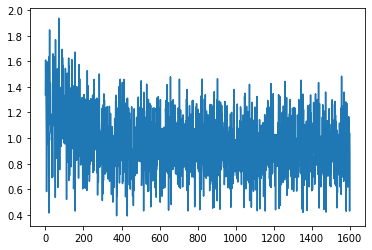

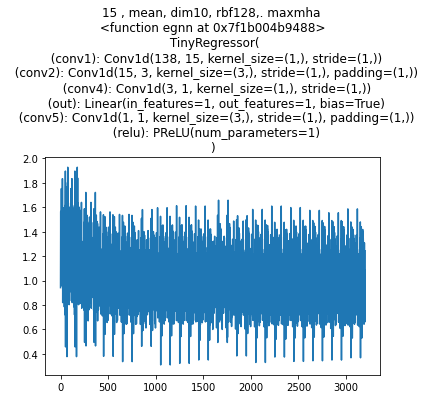

In [624]:
#plt.plot(
#plossess=[l for l in plosses if np.array(l).any()]
pl=[[l for l in ploss if l] for ploss in plosses][1:]
plt.plot(np.hstack(pl))#pl[1:])#[[l for l in ploss] for ploss in plosses][1:])#np.array(*[plosses[1:]]).flatten())#np.array([plossess[1:]]).flatten())
plt.show()
plt.plot(np.array([vlosses[1:]]).flatten())

plt.title(f"15 , mean, dim10, rbf128,. maxmha \n {egnn} \n {model}")
plt.show()

Epoch 0
 → avg loss: 1.0825

 → avg loss: 0.9971

Epoch 1
 → avg loss: 1.0160

 → avg loss: 0.9810

Epoch 2
 → avg loss: 1.0111

 → avg loss: 0.9757

Epoch 3
 → avg loss: 1.0072

 → avg loss: 0.9735

Epoch 4
 → avg loss: 1.0045

 → avg loss: 0.9720

Epoch 5
 → avg loss: 1.0042

 → avg loss: 0.9632

Epoch 6
 → avg loss: 1.0012

 → avg loss: 0.9638

Epoch 7
 → avg loss: 1.0005

 → avg loss: 0.9627

Epoch 8
 → avg loss: 1.0007

 → avg loss: 0.9655

Epoch 9
 → avg loss: 1.0001

 → avg loss: 0.9592

Epoch 10
 → avg loss: 0.9985

 → avg loss: 0.9623

Epoch 11
 → avg loss: 0.9975

 → avg loss: 0.9580

Epoch 12
 → avg loss: 0.9969

 → avg loss: 0.9627

Epoch 13
 → avg loss: 0.9948

 → avg loss: 0.9550

Epoch 14
 → avg loss: 0.9948

 → avg loss: 0.9595



/home/jrhoernschemeyer/.local/lib/python3.6/site-packages/ipykernel_launcher.py:156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


ValueError: setting an array element with a sequence.

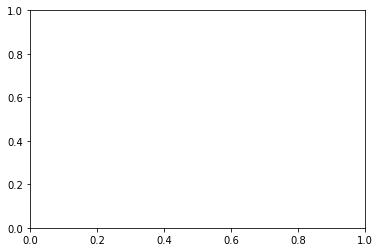

In [618]:


# ---------------------------------------------------------------
# 3) Get file list
# ---------------------------------------------------------------
paths = sorted(glob.glob("/home/jrhoernschemeyer/Desktop/data_prep/inputs/*.npz"))[:200]
tpaths=sorted(glob.glob("/home/jrhoernschemeyer/Desktop/data_prep/inputs/*.npz"))[200:300]
epoch_losses = []



# ---------------------------------------------------------------
# 4) Training loop
# ---------------------------------------------------------------
for epoch in range(15):
    print(f"Epoch {epoch}")
    net.train()
    mha.train()
    model.train()
    plosses.append(epoch_losses)
    #vlosses.append(vepoch_losses)
    epoch_losses = []
    vepoch_losses = []
    #vlosses=[]

    # for brevity, we’ll do just the first 2 files as before
    for path in list(np.array(paths)[np.random.permutation(len(paths))]):#np.shuffle(paths):
        # load the raw arrays
        a  = np.load(path, allow_pickle=True)
        zs = a["z"]       # array of length-N residues, each zs[i] is a (Li,3) array
        xs = a["pos"]     # (N,?) array of floats
        ys = a["pks"]     # (N,) array of targets

        optimizer.zero_grad()
        outs = []

        # now iterate residue-by-residue, converting each to a proper tensor
        for z_i, x_i, y_i in zip(zs, xs, ys):
            # convert this one example
            # — for z: a variable-length coordinate array
            z_t = torch.from_numpy(z_i[0].astype(np.int32)) \
                       .unsqueeze(0) \
                       .to(device)            # [1, Li, 3] or however your net expects it

            # — for x: your feature array, assumed float
            x_t = torch.from_numpy(x_i).unsqueeze(0).float().to(device)  # [1, ?]

            # forward pass
            out1, _         = net(z_t, x_t)           # adapt to your signature
            attn_out,__     = mha(A(out1[0]))
            distances = pairwise_distances(_)
            rbf = RadialBasisFunction()(distances)
            global_rbf_features = aggregate_rbf_features(rbf)
           

            
            out             = attn_out#out1#torch.matmul(__,attn_out)
            global_node_features    = out.max(dim=0)[0]   # [features]#
            #global_node_features = out
            # Concatenate node embeddings and RBF features
            global_embedding = torch.hstack([global_node_features, global_rbf_features]).unsqueeze(2)

            # Predict energy scalar
            energy_pred = model(global_embedding.permute(2,1,0))
            #attn_out,_ =       mha(A(out1[0]))
            #embedding       = global_node_feats # [features, 1]
            #energy_pred     = model(embedding.permute(0,2,1))#.unsqueeze(0))           # [1,1] or similar
            outs.append(torch.mean(energy_pred))#.squeeze())

        # stack and compute loss
        preds = torch.hstack(outs)  
        #preds=model.conv5(mha(A(preds.unsqueeze(1)))[0].permute(1,2,0)) 
        #preds=model.conv6(preds)[0]
        preds = model.conv5(preds.unsqueeze(0).unsqueeze(1))[0][0]          # [N]
        target = torch.from_numpy(ys).float().to(device)

        loss = criterion(preds, target)
        loss.backward()
        optimizer.step()

        epoch_losses.append(loss.item())

        #print(f"Epoch {epoch}")
    
############################
    net.eval()
    mha.eval()
    model.eval()
    vlosses.append(vepoch_losses)
        # for brevity, we’ll do just the first 2 files as before
    for path in tpaths:#np.shuffle(paths):
        # load the raw arrays
        a  = np.load(path, allow_pickle=True)
        zs = a["z"]       # array of length-N residues, each zs[i] is a (Li,3) array
        xs = a["pos"]     # (N,?) array of floats
        ys = a["pks"]     # (N,) array of targets

        #optimizer.zero_grad()
        outs = []

        # now iterate residue-by-residue, converting each to a proper tensor
        for z_i, x_i, y_i in zip(zs, xs, ys):
            # convert this one example
            # — for z: a variable-length coordinate array
            z_t = torch.from_numpy(z_i[0].astype(np.int32)) \
                    .unsqueeze(0) \
                    .to(device)            # [1, Li, 3] or however your net expects it

            # — for x: your feature array, assumed float
            x_t = torch.from_numpy(x_i).unsqueeze(0).float().to(device)  # [1, ?]

            # forward pass
            out1, _         = net(z_t, x_t)           # adapt to your signature
            attn_out,__     = mha(A(out1[0]))
            distances = pairwise_distances(_)
            rbf = RadialBasisFunction()(distances)
            global_rbf_features = aggregate_rbf_features(rbf)
        

            
            out             = attn_out#out1#torch.matmul(__,attn_out)
            global_node_features    = out.max(dim=0)[0]   # [features]#
            #global_node_features = out
            # Concatenate node embeddings and RBF features
            global_embedding = torch.hstack([global_node_features, global_rbf_features]).unsqueeze(2)

            # Predict energy scalar
            energy_pred = model(global_embedding.permute(2,1,0))
            #attn_out,_ =       mha(A(out1[0]))
            #embedding       = global_node_feats # [features, 1]
            #energy_pred     = model(embedding.permute(0,2,1))#.unsqueeze(0))           # [1,1] or similar
            outs.append(torch.mean(energy_pred))#.squeeze())

        # stack and compute loss
        preds = torch.hstack(outs)  
        #preds=model.conv5(mha(A(preds.unsqueeze(1)))[0].permute(1,2,0)) 
        #preds=model.conv5(preds.unsqueeze(1)))[0].permute(1,2,0
        #preds=model.conv6(preds)[0]
        preds = model.conv5(preds.unsqueeze(0).unsqueeze(1))[0][0]          # [N]
        target = torch.from_numpy(ys).float().to(device)
        
        loss = criterion(preds, target)
        #loss.backward()
        #optimizer.step()

        vepoch_losses.append(loss.item())




    avg = sum(epoch_losses) / len(epoch_losses)
    print(f" → avg loss: {avg:.4f}\n")

    avg = sum(vepoch_losses) / len(vepoch_losses)
    print(f" → avg loss: {avg:.4f}\n")


plt.plot(np.array([plosses[1:]]).flatten())
plt.show()
plt.plot(np.array([vlosses[1:]]).flatten())

plt.title(f"15 more on 40 and same 100 val/train . back to mean lol. \n {egnn} \n {model}")
plt.show()


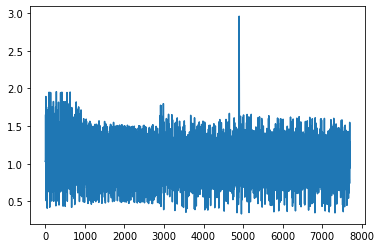

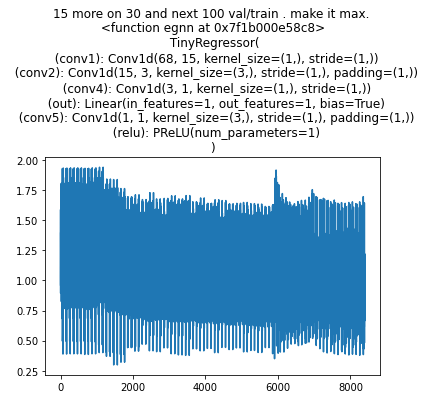

In [619]:
#plt.plot(
#plossess=[l for l in plosses if np.array(l).any()]
pl=[[l for l in ploss if l] for ploss in plosses][1:]
plt.plot(np.hstack(pl))#pl[1:])#[[l for l in ploss] for ploss in plosses][1:])#np.array(*[plosses[1:]]).flatten())#np.array([plossess[1:]]).flatten())
plt.show()
plt.plot(np.array([vlosses[1:]]).flatten())

plt.title(f"15 more on 30 and next 100 val/train . make it max. \n {egnn} \n {model}")
plt.show()

In [592]:
vlosses

[[],
 [0.899508535861969,
  1.2868506908416748,
  1.5879467725753784,
  1.0243287086486816,
  0.9565204381942749,
  1.3981674909591675,
  1.2877023220062256,
  1.1846489906311035,
  1.242971658706665,
  1.7535786628723145,
  1.065150260925293,
  1.383231520652771,
  0.979949951171875,
  1.0313562154769897,
  1.2394096851348877,
  1.0741939544677734,
  1.394232153892517,
  1.3488532304763794,
  1.2202410697937012,
  1.370771050453186,
  1.8056981563568115,
  1.44917631149292,
  1.3734955787658691,
  0.8246796131134033,
  1.0524523258209229,
  1.4290367364883423,
  1.6253019571304321,
  1.5597336292266846,
  1.5441193580627441,
  1.3882148265838623,
  1.3629143238067627,
  1.351447582244873,
  1.2780896425247192,
  1.0178959369659424,
  1.0857378244400024,
  1.1150583028793335,
  1.0924983024597168,
  1.563871145248413,
  1.4445525407791138,
  1.5256068706512451,
  0.7630441784858704,
  0.9934772253036499,
  1.2742379903793335,
  0.9898757934570312,
  1.537163257598877,
  1.0833227634429

In [586]:
epoch_losses

[1.9831972122192383,
 1.1622391939163208,
 1.3585346937179565,
 1.377789855003357,
 1.2946878671646118,
 1.5540916919708252,
 1.1850998401641846,
 1.833410382270813,
 1.0699846744537354,
 1.2697889804840088,
 0.9737502336502075,
 1.3776905536651611,
 1.0919345617294312,
 1.1215972900390625,
 1.263790488243103,
 1.588236927986145,
 1.267592191696167,
 1.3112530708312988,
 1.135438323020935,
 1.530171513557434,
 1.1100754737854004,
 1.7395572662353516,
 1.2381137609481812,
 1.0545830726623535,
 0.44600915908813477,
 1.4353677034378052,
 1.5791822671890259,
 0.766776442527771,
 1.2317508459091187,
 1.2572033405303955,
 1.2430756092071533,
 1.0674892663955688,
 1.0487223863601685,
 1.2305587530136108,
 1.233576774597168,
 1.6227929592132568,
 1.6222352981567383,
 1.086264729499817,
 1.0111403465270996,
 1.1932053565979004,
 0.6920369863510132,
 1.1283315420150757,
 1.0621758699417114,
 1.2063372135162354,
 1.223366618156433,
 1.3878508806228638,
 1.0304204225540161,
 1.3124886751174927,
 1

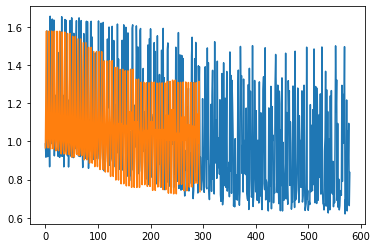

In [545]:
plt.plot(np.array([plosses[1:]]).flatten())
plt.plot(np.array([vlosses[1:]]).flatten())

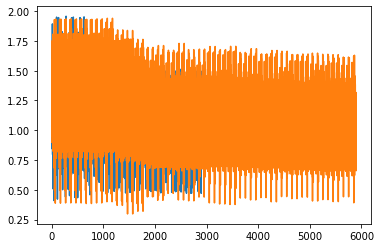

In [588]:
plt.plot(np.array([plosses[1:]]).flatten())
plt.plot(np.array([vlosses[1:]]).flatten())

In [411]:
plt.plot((out).detach().numpy())

tensor([-0.1165, -0.1113, -0.1121, -0.1109, -0.1114, -0.1111, -0.1166, -0.1113,
        -0.1120, -0.1109, -0.1116, -0.1134, -0.1133, -0.1150, -0.1085, -0.1165,
        -0.1113, -0.1121, -0.1124, -0.1124, -0.1075, -0.1165, -0.1113, -0.1121,
        -0.1124, -0.1124, -0.1075, -0.1165, -0.1113, -0.1118, -0.1119, -0.1129,
        -0.1145, -0.1087, -0.1165, -0.1113, -0.1118, -0.1119, -0.1129, -0.1145,
        -0.1087, -0.1165, -0.1113, -0.1118, -0.1119, -0.1129, -0.1145, -0.1087,
        -0.1165, -0.1113, -0.1117, -0.1141, -0.1062, -0.1165, -0.1113, -0.1118,
        -0.1119, -0.1129, -0.1145, -0.1087, -0.1165, -0.1113, -0.1121, -0.1109,
        -0.1114, -0.1111, -0.1165, -0.1113, -0.1121, -0.1124, -0.1124, -0.1075,
        -0.1165, -0.1113, -0.1121, -0.1109, -0.1114, -0.1111, -0.1165, -0.1113,
        -0.1117, -0.1141, -0.1062, -0.1165, -0.1113, -0.1121, -0.1109, -0.1114,
        -0.1111, -0.1166, -0.1113, -0.1120, -0.1109, -0.1116, -0.1134, -0.1133,
        -0.1150, -0.1085, -0.1165, -0.11

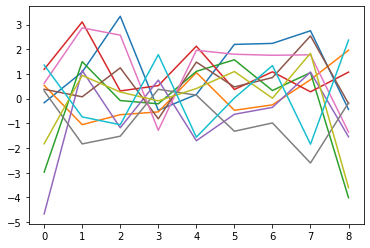

In [392]:
plt.plot((torch.sum(out1,dim=0)).detach().numpy())

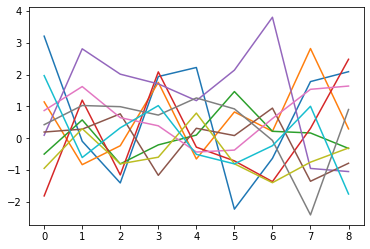

In [626]:
plt.plot((torch.sum(out1,dim=0)).detach().numpy())
#last run

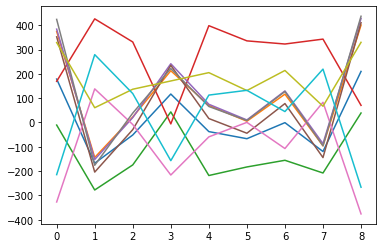

In [393]:
plt.plot((torch.sum(attn_out,dim=0)).detach().numpy())

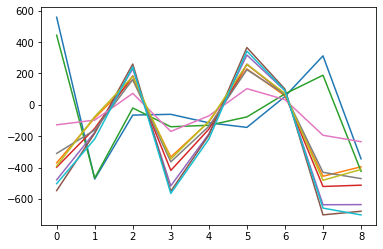

In [627]:
plt.plot((torch.sum(attn_out,dim=0)).detach().numpy())
#last

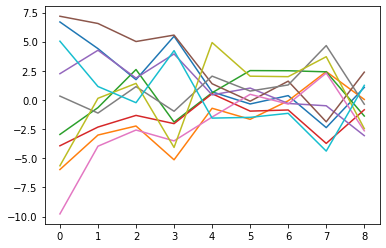

In [359]:
plt.plot((torch.sum(out1,dim=0)).detach().numpy())

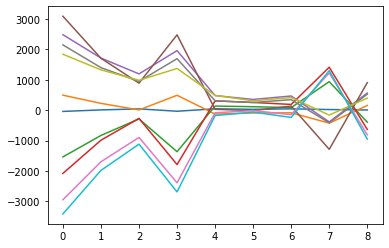

In [358]:
plt.plot((torch.sum(attn_out,dim=0)).detach().numpy())

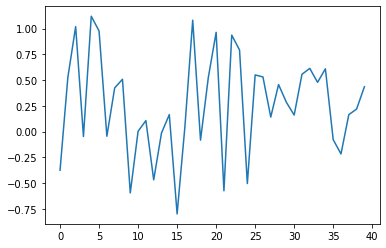

In [387]:
plt.plot((nn.Conv1d(1,1,16)(preds.unsqueeze(0).unsqueeze(1)))[0][0].detach().numpy())

In [373]:
y

tensor([[-0.9299, -0.7751, -0.4189, -0.5455, -0.2134,  0.5457]],
       grad_fn=<SelectBackward0>)

In [628]:
energy_pred[0]

tensor([[7.7034]], grad_fn=<SelectBackward0>)

In [629]:
y

tensor([ 9.4700e-01,  9.1660e-01, -1.2928e+00, -1.4400e-01, -7.9984e-01,
        -3.3954e-01, -4.4770e-01, -1.2265e+00, -4.6895e-01,  2.3220e-02,
         8.9260e-01, -3.3645e-01,  3.0330e-01, -2.1565e+00,  2.0230e-01,
         3.5460e+00, -4.8600e-02, -6.2718e-01,  5.5480e-01,  8.4870e-01,
        -1.9473e+00, -1.5117e+00, -5.3177e+00, -1.6932e+00,  4.5090e-01,
         4.7940e-01, -9.5098e-01, -1.7600e-03,  1.0433e+00, -1.2154e+00,
         1.4932e+00, -8.1300e-01, -1.1054e+00,  3.7310e-01, -1.4457e+00,
        -8.8684e-01,  7.2380e-01, -4.8368e-01, -3.1396e+00,  5.8790e-01,
         2.2360e-01, -1.1424e+00, -1.9726e+00,  1.0764e+00,  1.0062e+00,
         1.3198e+00, -1.1940e-01, -9.9335e-01, -1.0759e+00, -6.2380e-01,
         3.7070e-01, -1.5361e+00, -3.7710e-01, -1.2207e+00,  6.1920e-01])

In [ ]:
plt.plot((torch.sum(attn_out[0],dim=0)).detach().numpy())

In [214]:
model

TinyRegressor(
  (conv1): Conv1d(4, 3, kernel_size=(5,), stride=(1,))
  (conv2): Conv1d(3, 2, kernel_size=(4,), stride=(1,), padding=(1,))
  (conv3): Conv1d(2, 1, kernel_size=(2,), stride=(1,))
  (conv4): Conv1d(1, 1, kernel_size=(1,), stride=(1,))
  (relu): PReLU(num_parameters=1)
  (pool): AdaptiveMaxPool2d(output_size=(1, 1))
)

toSmoothing / feature extracion: bigger kernels are like low-pass filters over your per-residue features, helping the network learn patterns of length up to five (e.g. short motifs or structural patterns).

In [144]:
out1.max(dim=0)[0]

tensor([[ 1.7802,  2.4703,  2.3014],
        [ 0.1016,  0.7463,  0.4927],
        [-1.4158,  0.8296,  0.7363],
        [-2.5257,  0.4289, -1.8539],
        [-1.5596,  0.7340,  0.8577],
        [-1.5712,  0.5538,  1.7684],
        [-0.1317,  1.1963,  1.5485],
        [-2.9916,  0.4646,  1.7982],
        [ 3.3215,  5.4421,  3.5472]], grad_fn=<MaxBackward0>)

the öast relu fucks it up??

![
    

](attachment:image.png)

it stops learning

In [94]:
np.array([plosses[1:]]).flatten()

array([1.44002295, 1.54307771, 1.43986702, 1.54294503, 1.43971157,
       1.54281235, 1.43955588, 1.54267967, 1.43940032, 1.54254687,
       1.43924463, 1.54241407, 1.43908942, 1.54228151, 1.43894124,
       1.54214931, 1.43879342, 1.54201722, 1.43864596, 1.54188514,
       1.4384985 , 1.54175329, 1.4383508 , 1.54162133, 1.43820333,
       1.54148948, 1.43805599, 1.5413574 , 1.43790841, 1.54122543,
       1.43776083, 1.54109359, 1.43761325, 1.54096162, 1.43746555,
       1.54082954, 1.43731797, 1.54069746, 1.43717039, 1.54056561,
       1.43702269, 1.54043341, 1.43687475, 1.54030132, 1.43672717,
       1.54016924, 1.43657935, 1.54003692, 1.43643153, 1.53990471,
       1.43628359, 1.53977251, 1.43613577, 1.53964019, 1.43598783,
       1.53950799, 1.43584001, 1.53937554])

Text(0.5, 1.0, 'chat fixed LOL')

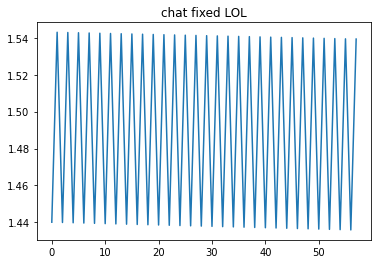

In [95]:
plt.plot(np.array([plosses[1:]]).flatten())
plt.title("chat fixed LOL")

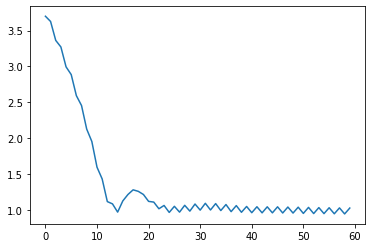

In [11]:
plt.plot(plosses)